### **This notebook explores user-based features from a fictional travel start-up TravelTide.**  
#### The purpose is to develope user segments for a marketing rewarding program

In [2]:
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from customer_segmentation.utils import db_utils, file_io, plot_utils, preprocessing

load_dotenv(override=True)

modules_to_reload = [db_utils, file_io, preprocessing, plot_utils]
for module in modules_to_reload:
    importlib.reload(module)

# Set pandas to display all columns
pd.set_option("display.max_columns", None)

### **Query data**

In [35]:
cohort = db_utils.read_from_db_to_df("customer_data_model")

display(cohort.shape)
display(pd.DataFrame({"dtypes": cohort.dtypes}).T)
cohort.head(3)

(187268, 32)

,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_checked_bags,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,flight_booked,hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
dtypes,int64,int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,float64,int64,int64,float64,float64,int64,int64,float64,float64


,user_id,age,has_children,is_married,cnt_trips,cnt_cancellations,avg_diff_trip_days,days_last_trip,avg_days_advance_booking,avg_travel_days,avg_seats,avg_checked_bags,avg_flight_travel_days,sum_flight_price,avg_distance_km,sum_distance_km,avg_rooms,avg_hotel_nights,sum_hotel_price,min_signup_date,cnt_sessions,sum_page_clicks,days_active,avg_session_duration_seconds,flight_booked,hotel_booked,sum_flight_discount,sum_hotel_discount,cnt_flight_discount,cnt_hotel_discount,avg_flight_discount,avg_hotel_discount
0,232802,46,1,1,2.0,0.0,31.0,241,8.0,6.0,2.0,0.0,3.0,332.37,1809.0,1809.0,2.0,5.0,1548.0,2022-07-01,10,200,291,149.0,1,2,33.24,0.0,1,2,0.1,0.18
1,232803,53,1,1,5.0,0.0,62.0,75,8.0,4.0,2.0,1.0,3.0,798.57,1368.0,5471.0,2.0,4.0,8262.0,2022-07-01,7,120,324,126.0,4,5,23.72,402.2,2,4,0.1,0.13
2,232804,35,0,0,2.0,0.0,15.0,125,8.0,5.0,1.0,1.0,5.0,669.31,3444.0,6887.0,1.0,4.0,1193.0,2022-07-01,8,101,382,94.0,2,2,38.61,40.0,2,2,0.1,0.08


### **Preprocessing**

In [36]:
# convert data types
cohort["user_id"] = cohort["user_id"].astype(str)
cohort["min_signup_date"] = pd.to_datetime(cohort["min_signup_date"])

In [37]:
# check number of days per month
cohort["min_signup_month"] = cohort["min_signup_date"].dt.to_period("M")

days_per_month = (
    cohort.groupby("min_signup_month")["min_signup_date"]
    .apply(lambda x: x.dt.date.nunique())
)
days_per_month

min_signup_month
2022-07    31
2022-08    31
2022-09    30
2022-10    31
2022-11    30
2022-12    31
2023-01    31
2023-02    28
2023-03    31
2023-04    30
2023-05    31
2023-06    29
2023-07     3
Freq: M, Name: min_signup_date, dtype: int64

In [38]:
# remove July 2023
cohort = cohort[cohort["min_signup_date"] < "2023-07-01"]

**Create meaningful features**

In [ ]:
# activity & engagement
cohort["month_active"] = cohort["days_active"] / 30
cohort["sessions_per_month"] = cohort["cnt_sessions"] / cohort["month_active"]
cohort["trips_per_month"] = cohort["cnt_trips"] / cohort["month_active"]
cohort["page_click_per_session"] = cohort["sum_page_clicks"] / cohort["cnt_sessions"]
cohort["trips_per_session"] = cohort["cnt_trips"] / cohort["cnt_sessions"]

# bookings & cancellations
cohort["total_booking_value"] = cohort["sum_hotel_price"] + cohort["sum_flight_price"]
cohort["avg_booking_value"] = cohort["total_booking_value"] / cohort["cnt_trips"]
cohort["customer_value_per_month"] = (
    cohort["total_booking_value"] / cohort["month_active"]
)
cohort["flight_booking_value"] = (
    cohort["sum_flight_price"] / cohort["total_booking_value"]
)
cohort["hotel_booking_value"] = (
    cohort["sum_hotel_price"] / cohort["total_booking_value"]
)

cohort["cancellation_rate"] = cohort["cnt_cancellations"] / cohort["cnt_trips"]

# discounts
cohort["total_discount_rate"] = round(
    (cohort["sum_flight_discount"] + cohort["sum_hotel_discount"])
    / cohort["total_booking_value"],
    2,
)
cohort["discount_per_km"] = cohort["sum_flight_discount"] / cohort["sum_distance_km"]
cohort["flight_discount_rate"] = cohort["cnt_flight_discount"] / cohort["flight_booked"]
cohort["hotel_discount_rate"] = cohort["cnt_hotel_discount"] / cohort["hotel_booked"]

**Data clean-up**

In [40]:
# check features with missing data
display(preprocessing.missing_data(cohort))

,Total,Percentage
discount_per_km,39291,20.981609
flight_booking_value,24130,12.885552
total_discount_rate,24130,12.885552
hotel_booking_value,24130,12.885552
avg_booking_value,24129,12.885018
cancellation_rate,24129,12.885018
hotel_discount_rate,14051,7.503311
flight_discount_rate,13097,6.993870


In [41]:
# handle inf and na values
cohort = cohort.replace([np.inf, -np.inf], 0).fillna(0)

**Check some metrics**

In [42]:
share_user_not_booked = (
    cohort[cohort["cnt_trips"] == 0]["user_id"].nunique() / cohort["user_id"].nunique()
)
print(f"Percent share of users without bookings: {share_user_not_booked * 100:.1f}%")

high_booking_values = (
    cohort[(cohort["avg_booking_value"] >= 5000) & (cohort["cnt_trips"] > 0)][
        "user_id"
    ].nunique()
    / cohort["user_id"].nunique()
)
print(
    f"Percent share of users with high booking values: {high_booking_values * 100:.1f}%"
)
flight_discount_rate = np.mean(cohort["flight_discount_rate"])
print(f"Average flight discount rate: {flight_discount_rate * 100:.1f}%")
hotel_discount_rate = np.mean(cohort["hotel_discount_rate"])
print(f"Average hotel discount rate: {hotel_discount_rate * 100:.1f}%")
cancellation_rate = np.mean(cohort["cancellation_rate"])
print(f"Average cancellation rate: {cancellation_rate * 100:.1f}%")

Percent share of users without bookings: 12.9%
Percent share of users with high booking values: 1.3%
Average flight discount rate: 51.7%
Average hotel discount rate: 41.1%
Average cancellation rate: 1.5%


**Remove absolute and redundant metrics**

In [43]:
# remove columns not necessary for further analysis
columns_to_drop = [
    "cnt_flight_discount",
    "cnt_hotel_discount",
    "cnt_cancellations",
    "cnt_sessions",
    "sum_distance_km",
    "sum_flight_discount",
    "sum_flight_price",
    "sum_hotel_discount",
    "sum_hotel_price",
    "total_booking_value",
    "sum_page_clicks",
    "days_active",
    "min_signup_month"
]
cohort = cohort.drop(columns=columns_to_drop)

In [61]:
# split features to binary and numeric
binary_cols = preprocessing.get_binary_columns(cohort)
numeric_cols = cohort.select_dtypes(include=[np.number]).columns.drop(binary_cols)
numeric_cols = numeric_cols.drop("month_active")

### **Explore distributions**

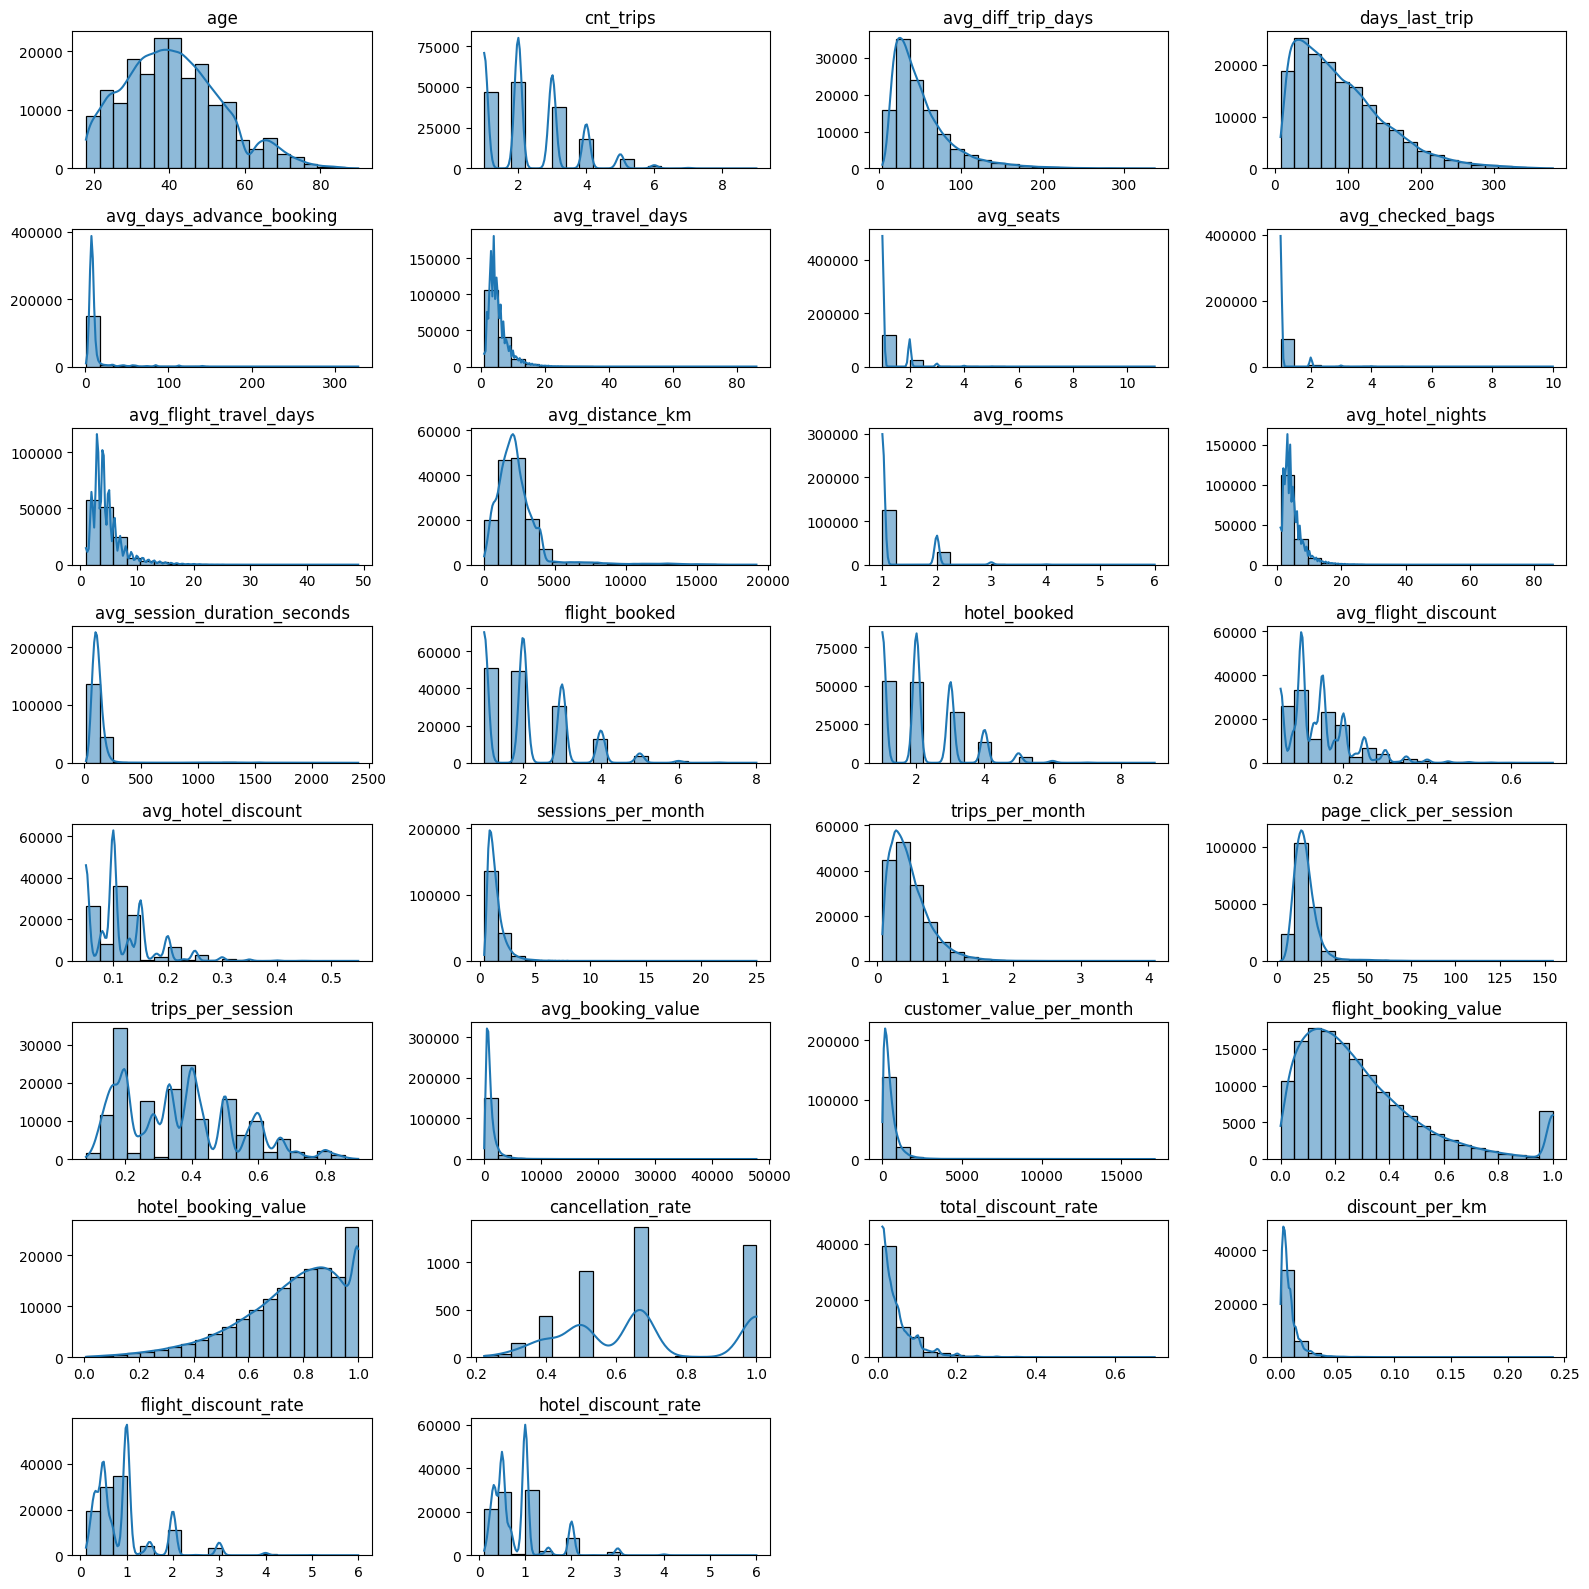

In [60]:
plot_utils.plot_univariate_series(
    df=cohort,
    metrics=numeric_cols.to_list(),
    n_cols=4,
    set_kde=True,
    set_bins=20,
    plot_type=sns.histplot,
)

**Aggregated values per first session per user**

In [54]:
# aggregate by sign up date
user_grouped_per_min_date = (
    cohort.groupby(["min_signup_date"])
    .agg(
        cnt_user=("user_id", "nunique"),
        avg_days_advanced_booking=("avg_days_advance_booking", "mean"),
        avg_diff_days=("avg_diff_trip_days", "mean"),
        discount_rate=("total_discount_rate", "mean"),
        discount_per_km=("discount_per_km", "mean"),
        cancellation_rate=("cancellation_rate", "mean"),
        median_booking_value=("avg_booking_value", "median"),
        days_last_trip=("days_last_trip", "mean"),
        avg_travel_days=("avg_travel_days", "mean"),
        trips_per_month=("trips_per_month", "mean"),
        sessions_per_month=("sessions_per_month", "mean"),
        page_click_per_session=("page_click_per_session", "mean"),
    )
    .reset_index()
)

**discover mean values per date of signed-up**  
- on average, about 600 user are active per day  
- most users book between 5 and 15 days in advance the trip begin  
- the average days between bookings is 20 days
- median booking value is about $700  
- on average, 90 days was the last booking of user
- on average, user book a trip of 5 days


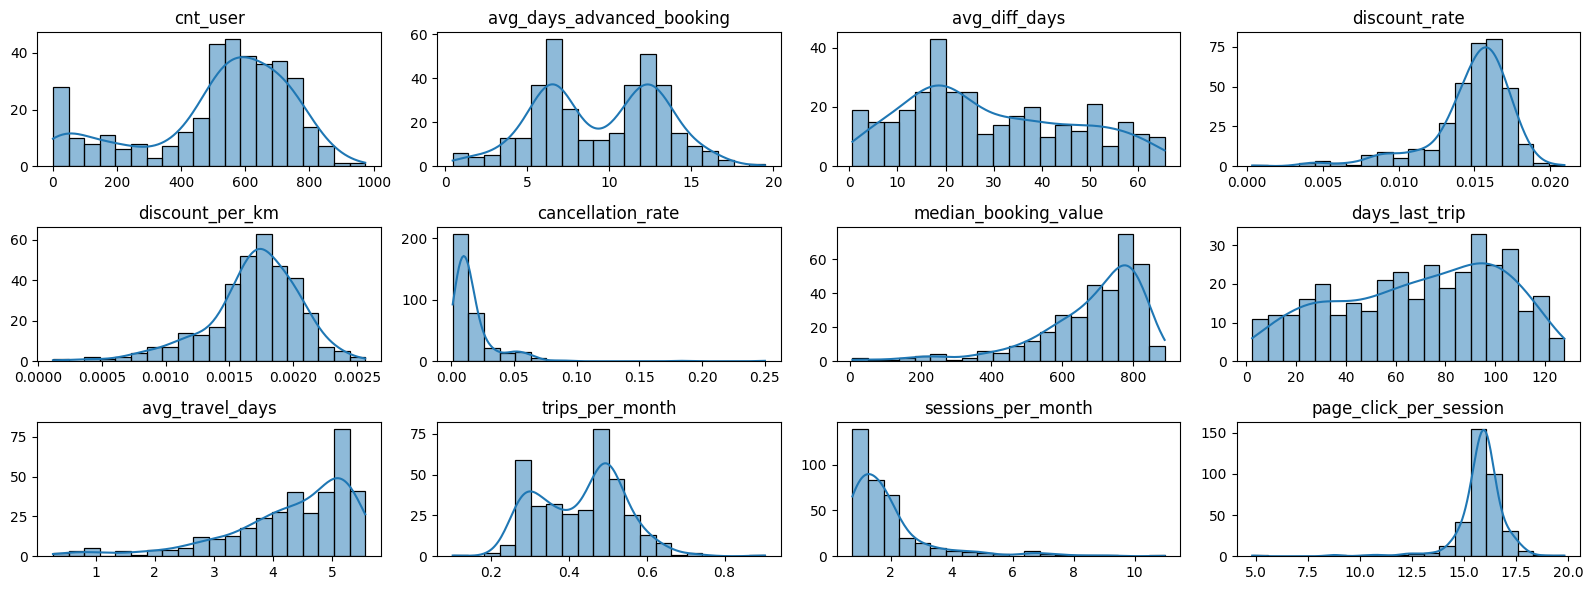

In [55]:
metrics = user_grouped_per_min_date.select_dtypes(include=[np.number]).columns.to_list()

plot_utils.plot_univariate_series(
    df=user_grouped_per_min_date, metrics=metrics, n_cols=4, plot_type=sns.histplot
)

**discover user pattern over time**  
 
- amount of user per month decreases
- cancellation rate increases with high peaks in June 2023
- mean booking value decreases, but bookings increase
- sessions per month increases with page clicks per session quite stable

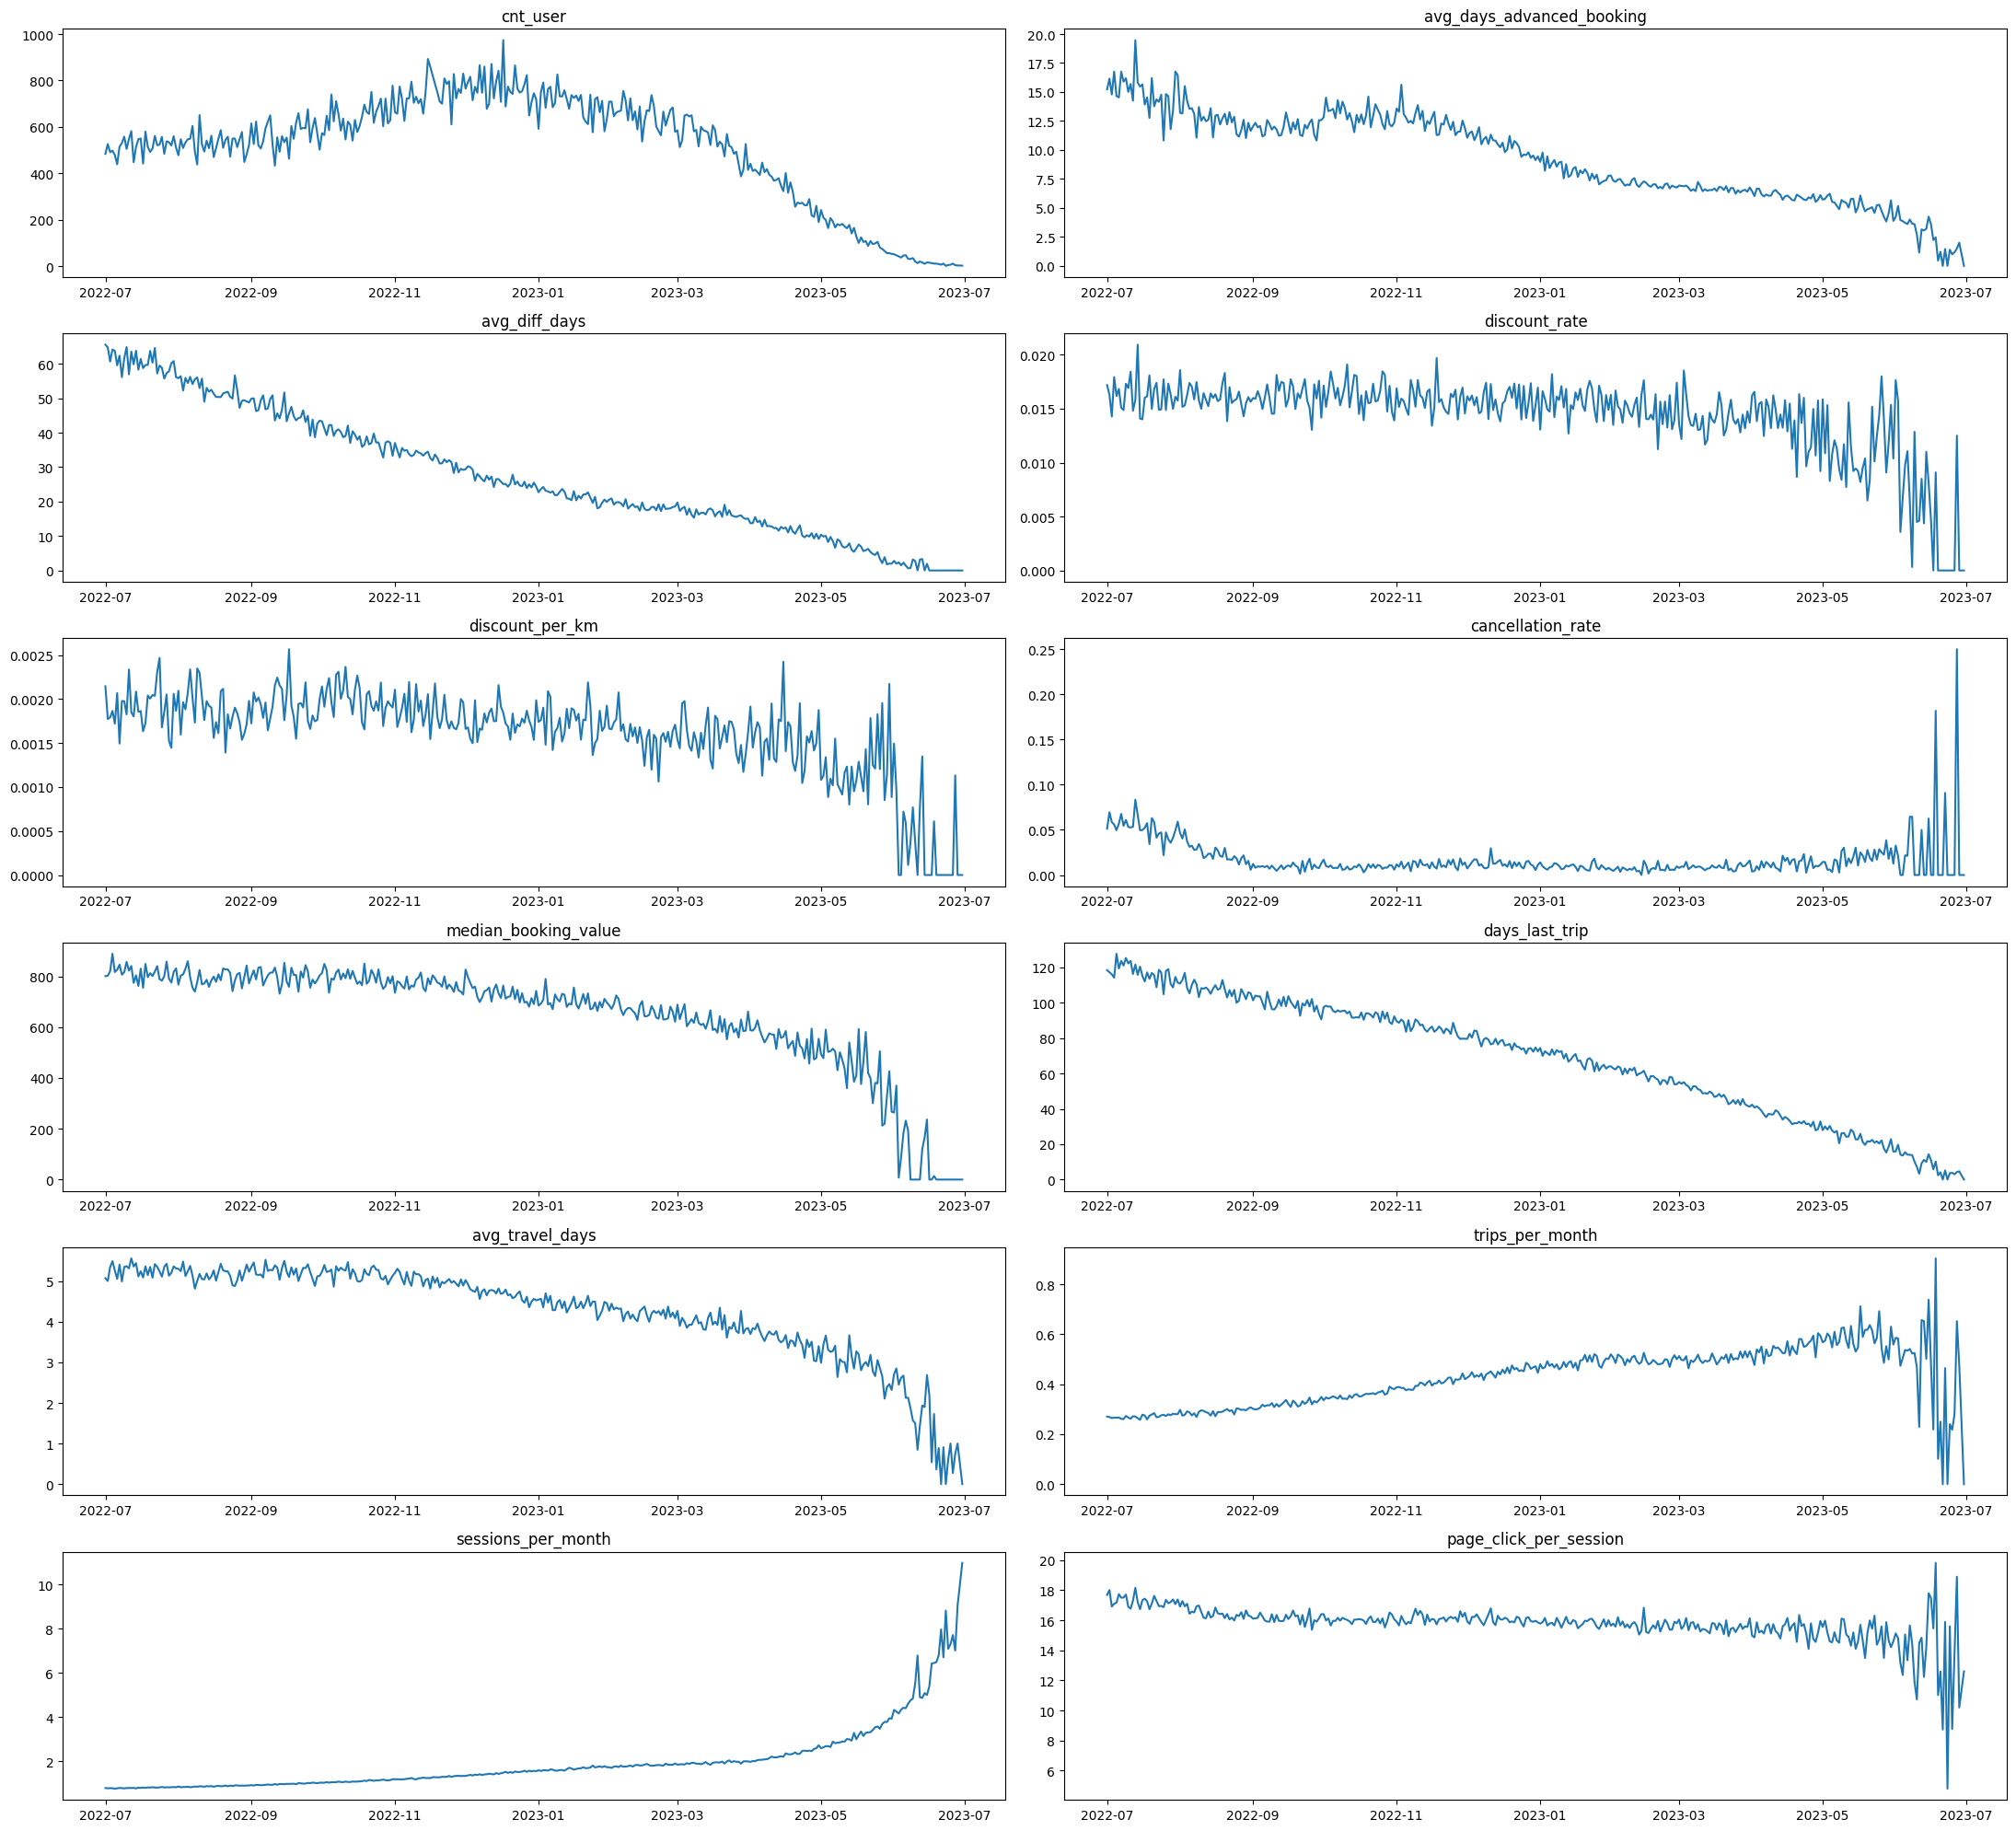

In [56]:
plot_utils.plot_time_series(
    df=user_grouped_per_min_date,
    x=user_grouped_per_min_date.columns.values[0],
    y=list(user_grouped_per_min_date.columns.values[1:]),
)

### **Write modified cohort data to local db for RFM & Segmentation**

In [ ]:
db_utils.write_df_to_db(df=cohort, tablename="customer_cohort")